In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")
print("Path to dataset files:", path)
csv_file_path = path + "/StudentPerformanceFactors.csv"

100%|██████████| 93.9k/93.9k [00:00<00:00, 16.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/lainguyn123/student-performance-factors/versions/7


In [ ]:
import pandas as pd

# Create df
df = pd.read_csv(csv_file_path)

In [ ]:
# Bagging/Random Forest (wihtout any feature selction or hyperparameter optimization)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mseRF1 = mean_squared_error(y_test, y_pred)
r2RF1 = r2_score(y_test, y_pred)

metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'R-squared (R²)'],
    'Value': [mseRF1, r2RF1]
}

results_table = pd.DataFrame(metrics)

print(results_table)

                     Metric     Value
0  Mean Squared Error (MSE)  7.095652
1            R-squared (R²)  0.498011


In [ ]:
# Bagging/Random Forest (with feature selction and hyperparameter optimization)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

X = df[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#The pipeline was created to implement the feature selection and model at the same time
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)), #selects the top k features based on a scoring function in this case regression
    ('regressor', RandomForestRegressor(random_state=15))
])

#hyperparameter optimization
#sets mins and maxes for forests
param_grid = {
    'feature_selection__k': [2, 3],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

#this creates forests bases on the params specified in the grid. it also uses k fold validation to create multiple forests, which are able to be compared
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mseRF2 = mean_squared_error(y_test, y_pred)
r2RF2 = r2_score(y_test, y_pred)

metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'R-squared (R²)'],
    'Value': [mseRF2, r2RF2]
}

results_table = pd.DataFrame(metrics)

print("\n")
print(results_table)
print("\n")
print("Best Parameters:", grid_search.best_params_)
print("Selected Features:", X.columns[best_model.named_steps['feature_selection'].get_support()])


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,




                     Metric     Value
0  Mean Squared Error (MSE)  4.693831
1            R-squared (R²)  0.650979


Best Parameters: {'feature_selection__k': 3, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Selected Features: Index(['Hours_Studied', 'Attendance', 'Previous_Scores'], dtype='object')


In [ ]:
# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the Student Performance Factors dataset
df = pd.read_csv(csv_file_path)
X = df[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = df['Exam_Score']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

# Initialize the KNN Model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

# Evaulate with MSE and R^2
mseKNN1 = mean_squared_error(y_test, y_pred)
r2KNN1 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mseKNN1)
print("R^2 Score:", r2KNN1)

Mean Squared Error: 5.868045049588166
R^2 Score: 0.5640171546532249


In [ ]:
#KNN (with feature selction and hyperparameter optimization)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


X = df[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

#feature tuning polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#standard features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

#hyperparameter optimization grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9]
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly_scaled, y_train)

#get the best knn model
best_knn_model = grid_search.best_estimator_

#use the optimized model to predict
y_pred = best_knn_model.predict(X_test_poly_scaled)

mseKNN2 = mean_squared_error(y_test, y_pred)
r2KNN2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mseKNN2)
print("R² Score:", r2KNN2)


Mean Squared Error: 4.771352795054259
R² Score: 0.6454989779113847


                   Model       MSE        R²
0          Random Forest  7.095652  0.498011
1  Random Forest (FS/HP)  4.371055  0.660399
2                    KNN  5.868045  0.564017
3            KNN (FS/HP)  4.771353  0.645499


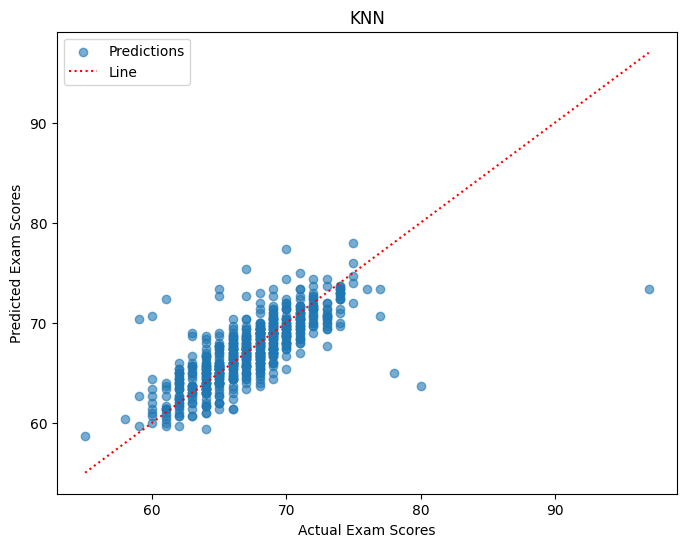

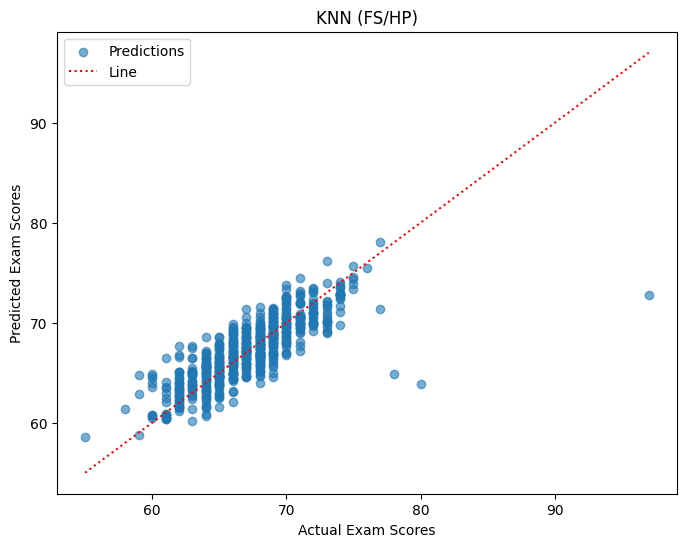

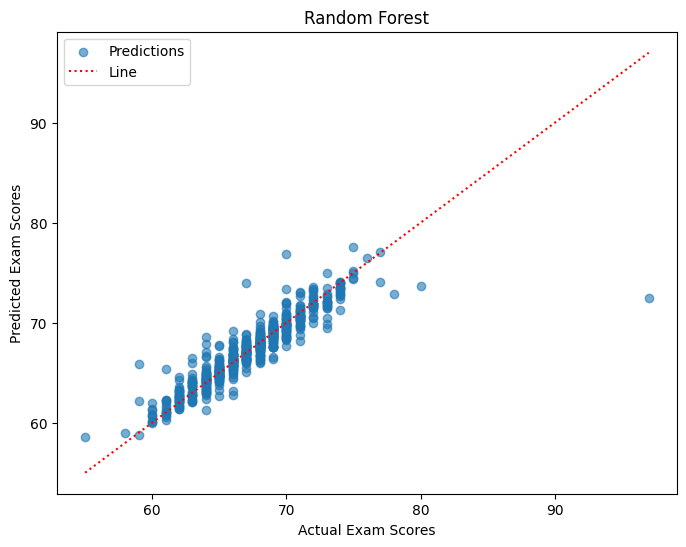

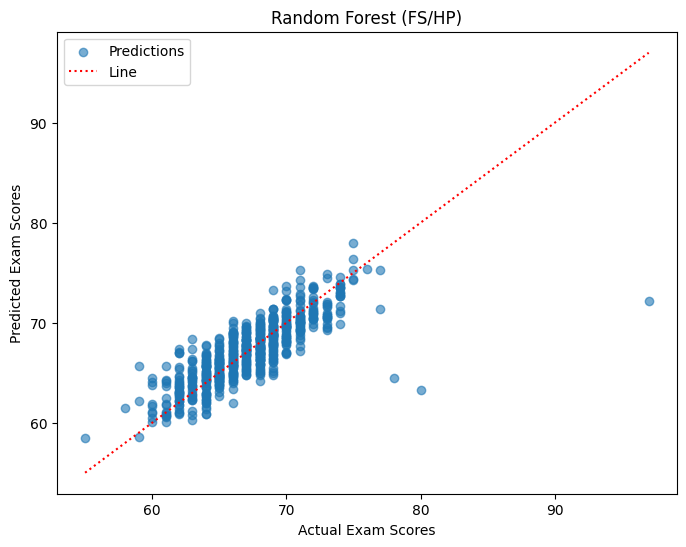

In [ ]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

# Create dictionary for storing results
results = {
    'Model': ['Random Forest', 'Random Forest (FS/HP)', 'KNN', 'KNN (FS/HP)'],
    'MSE': [mseRF1, mseRF2, mseKNN1, mseKNN2],
    'R²': [r2RF1, r2RF2, r2KNN1, r2KNN2]
}

# Turn it into a DataFrame for later use
model_results = pd.DataFrame(results)
print(model_results)

# Display as small scatterplot to showcase differences in scores
results_df = pd.DataFrame(results);
fig = px.scatter(results_df, x='MSE', y='R²', text='Model', title="Model Performance", labels={'MSE': 'Mean Squared Error', 'R²': 'R-Squared Score'}, template='plotly')
fig.update_traces(textposition='top center')
fig.show()

# Scatterplots showing model accuracy

# KNN
plt.figure(figsize=(8, 6))
plt.scatter(y_test, knn_model.predict(X_test), alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dotted', label='Line')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('KNN')
plt.legend()
plt.show()

# KNN (FS/HP)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_knn_model.predict(X_test_poly_scaled), alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dotted', label='Line')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('KNN (FS/HP)')
plt.legend()
plt.show()

# Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf.predict(X_test), alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dotted', label='Line')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Random Forest')
plt.legend()
plt.show()

# Random Forest (FS/HP)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_model.predict(X_test), alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dotted', label='Line')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Random Forest (FS/HP)')
plt.legend()
plt.show()